In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
%matplotlib notebook

## Read in netCDF data

In [2]:
from scipy.io import netcdf_file

# https://resources.marine.copernicus.eu/product-download/SEALEVEL_EUR_PHY_L4_MY_008_068
dataset = 'data10102019'
f = netcdf_file(f"{dataset}.nc")
f.variables

{'ugos': <scipy.io._netcdf.netcdf_variable at 0x7f7962a9de80>,
 'vgos': <scipy.io._netcdf.netcdf_variable at 0x7f793a3774c0>,
 'vgosa': <scipy.io._netcdf.netcdf_variable at 0x7f793a3774f0>,
 'crs': <scipy.io._netcdf.netcdf_variable at 0x7f793a377580>,
 'err_vgosa': <scipy.io._netcdf.netcdf_variable at 0x7f793a377610>,
 'latitude': <scipy.io._netcdf.netcdf_variable at 0x7f793a3776d0>,
 'sla': <scipy.io._netcdf.netcdf_variable at 0x7f793a377760>,
 'ugosa': <scipy.io._netcdf.netcdf_variable at 0x7f793a3777f0>,
 'flag_ice': <scipy.io._netcdf.netcdf_variable at 0x7f793a377940>,
 'adt': <scipy.io._netcdf.netcdf_variable at 0x7f793a3779d0>,
 'err_ugosa': <scipy.io._netcdf.netcdf_variable at 0x7f793a377a90>,
 'time': <scipy.io._netcdf.netcdf_variable at 0x7f793a377b20>,
 'longitude': <scipy.io._netcdf.netcdf_variable at 0x7f793a377b80>,
 'err_sla': <scipy.io._netcdf.netcdf_variable at 0x7f793a377c10>}

In [3]:
lat = f.variables['latitude'].data
long = f.variables['longitude'].data
vel_x = f.variables['ugos'].data.squeeze()
print(vel_x.shape[0])
vel_y = f.variables['vgos'].data.squeeze()
print(vel_y.shape)
from common_functions import interpolate_missing_point

imputed_vel_x = interpolate_missing_point(vel_x, np.ma.masked_invalid(vel_x).mask)
imputed_vel_y = interpolate_missing_point(vel_y, np.ma.masked_invalid(vel_y).mask)

320
(320, 81)


In [4]:
from scipy.interpolate import RegularGridInterpolator
from scipy.integrate import solve_ivp
from scipy.spatial.distance import euclidean


# first build an interpolator over the x and y velocity
# for now dont use any proper coordinates just [0,m]*[0,n]
m,n = imputed_vel_x.shape
i = np.linspace(0, m, m)
j = np.linspace(0, n, n)
method = "linear"

interp_vel_x = RegularGridInterpolator((i, j), imputed_vel_x, method=method)
interp_vel_y = RegularGridInterpolator((i, j), imputed_vel_y, method=method)

def rhs(t, x):
    return [interp_vel_x(x).squeeze(), interp_vel_y(x).squeeze()]
    
def streamline(i,j, *, steps, step_size, dist_tol, winding_tol):
    #print(i,j, flush=True)
    winding_angle = 0
    theta_prev = 0
    closed = False
    
    start_i = i
    start_j = j
    
    # streamline path
    trajectory = [[i,j]]
    
    for k in range(steps):
        try:
            # get velocities
            v = rhs(0,[i,j])
        except:
            # stream line leaves domain
            break
        
        # integrate
        i += step_size*v[1]
        j += step_size*v[0]
        
        # get angle
        theta = np.arctan2(v[1], v[0])
        
        if k > 1:
            winding_angle += theta - theta_prev
           
        if k > 100 and (dist:=euclidean([i,j],[start_i,start_j])) < dist_tol:
            closed = True
            break
            
            
        theta_prev = theta
        trajectory.append([i,j])
    
    if (winding_angle % (2*np.pi) < winding_tol or winding_angle % (-2*np.pi) < winding_tol) and closed:
        print(f"{dist=} {winding_angle=} {closed=}")
        return np.asarray(trajectory).T
    return None
        
        
from multiprocessing import Pool
from functools import partial
from itertools import product

step = 5

i_points = range(0, imputed_vel_x.shape[0], step)
j_points = range(0, imputed_vel_x.shape[1], step)

with Pool() as p:
    func = partial(streamline, steps=5000, step_size=0.1, dist_tol=0.3, winding_tol=0.3)
    
    res = p.starmap(func, product(i_points,j_points))

eddies = []

for result in res:
    if result is not None:
        eddies.append(np.mean(result, axis=-1))

eddies = np.asarray(eddies)


dist=0.284950560885431 winding_angle=-0.14148180517221576 closed=True
dist=0.21936425106184151 winding_angle=0.021374582218616822 closed=Truedist=0.10434996526220096 winding_angle=0.14588354090772504 closed=True
dist=0.23002505433127532 winding_angle=0.19144603920683423 closed=True

dist=0.2620479183721108 winding_angle=0.07330142131633788 closed=True
dist=0.149259473470533 winding_angle=-0.08440313519535869 closed=True
dist=0.07987609133329865 winding_angle=0.03131732530448694 closed=True
dist=0.25605499339096244 winding_angle=-0.09007394342825437 closed=True
dist=0.10607731214132965 winding_angle=0.2313120388686407 closed=True
dist=0.29945902265577107 winding_angle=0.15937780994143913 closed=True
dist=0.28053851336195934 winding_angle=-0.1436450998925292 closed=True
dist=0.2991601049717739 winding_angle=-0.042842466726241035 closed=True
dist=0.1598990261309215 winding_angle=0.3074704293576549 closed=True
dist=0.2965472966495893 winding_angle=-0.2870419214898363 closed=True
dist=0.259

dist=0.29132160938458984 winding_angle=-0.002524573987559453 closed=True
dist=0.2925476492125518 winding_angle=-0.01796929112536272 closed=True
dist=0.296851329636498 winding_angle=-5.8955279510943335 closed=True
dist=0.2894008813170203 winding_angle=0.023591361922273346 closed=True
dist=0.2349324278444402 winding_angle=0.10676401795109287 closed=True
dist=0.2989577263374073 winding_angle=-0.22459250577611778 closed=True
dist=0.29320773551554313 winding_angle=0.022974584371846074 closed=True
dist=0.29047228569567 winding_angle=-0.09530044116411451 closed=True
dist=0.11399859578965486 winding_angle=-0.19185391050889167 closed=True
dist=0.2949888239867586 winding_angle=0.25088420680958423 closed=True
dist=0.12323312451811223 winding_angle=0.12480941893748287 closed=True
dist=0.2756878384256403 winding_angle=-0.11168581678006717 closed=True
dist=0.19843659615209133 winding_angle=0.07238676515598863 closed=True
dist=0.17047076200378763 winding_angle=0.7759920690554696 closed=True
dist=0.12

<IPython.core.display.Javascript object>


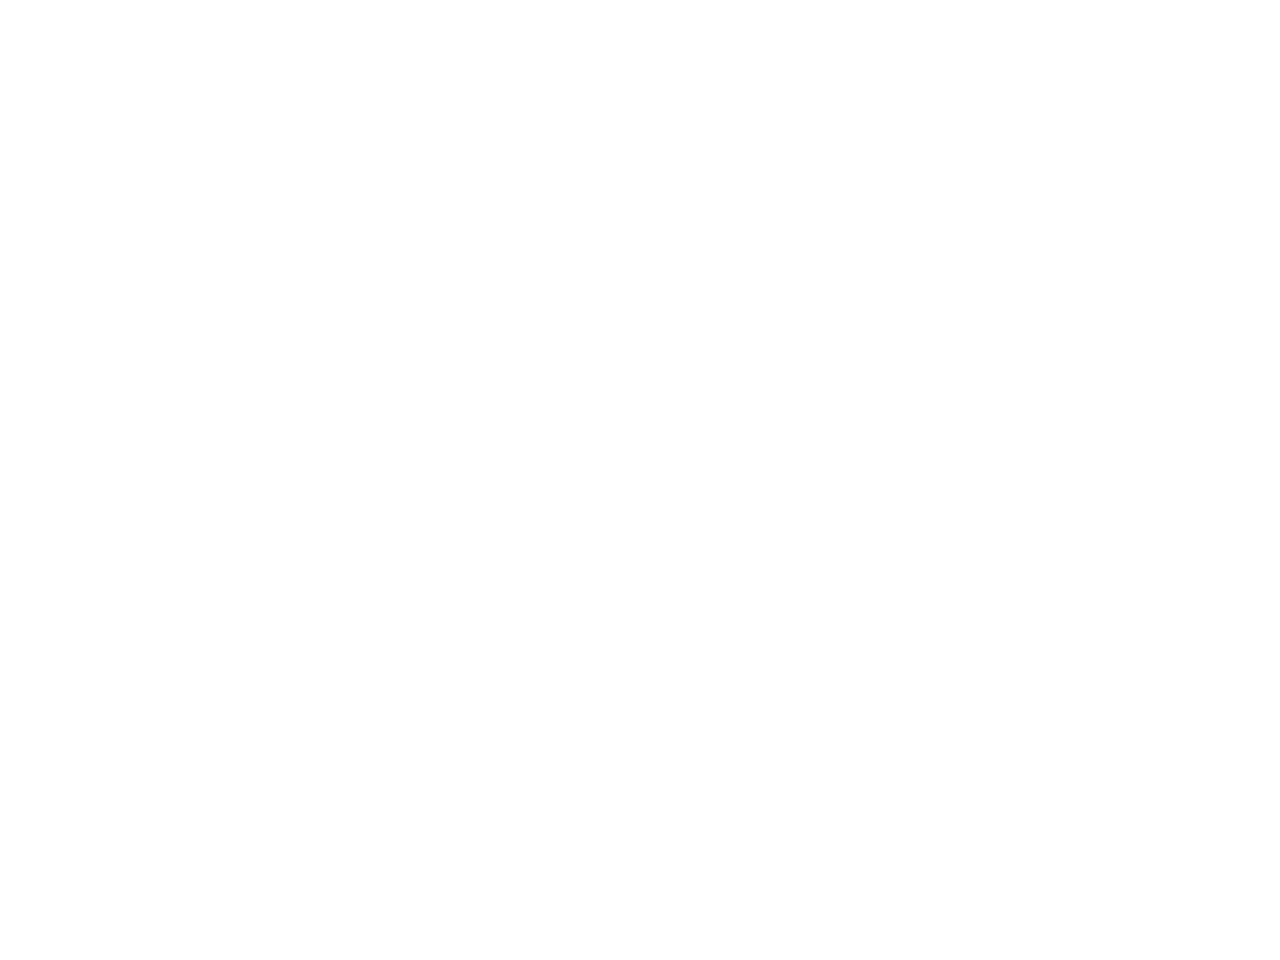

In [5]:
plt.figure(dpi = 200)
plt.imshow(np.hypot(imputed_vel_x, imputed_vel_y), origin='lower',)
plt.plot(eddies[:,1], eddies[:,0], 'w.', markersize=5, label="Eddy Centre")
plt.quiver(imputed_vel_x, imputed_vel_y, color='r', scale=5, zorder=2)

In [8]:
eddies = np.round(eddies).astype(int)
np.savetxt(f"windingangle-{dataset}.csv",np.column_stack([lat[eddies[:,0]], long[eddies[:,1]]]), delimiter=',')